<a href="https://colab.research.google.com/github/mekhanikaladvantage/vneural-pdes/blob/main/DeepRitz_Jax_10D_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Imports
'''
!pip install optax #must be run at the start of the session.

from jax import jit, grad, vmap, value_and_grad
from jax import random, nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import math

# JAX_DEBUG_NANS=True
JAX_DEBUG_NANS = False
from jax.config import config
# config.update("jax_debug_nans",True)
config.update("jax_debug_nans",False)
config.parse_flags_with_absl()

#set 64 bit precision
# JAX_ENABLE_X64=True
JAX_ENABLE_X64=False

%xmode context
# %xmode verbose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Exception reporting mode: Context


Hyperparameters
==========

In [ ]:
#set hyperparameters

# this creates random parameters for the weights and biases of a given node
def random_layer_params(m:int,n:int,key, scale = 2e-1) -> tuple:
    '''
    currenly using the normalized Bengio-Glorot initialization.
    '''
    w_key, b_key = random.split(key)
    # return scale * random.normal(w_key,(n,m)), scale * random.normal(b_key,(n,1))
    minval = -6/(jnp.sqrt(m + n)) 
    # minval = 1
    maxval = -1*minval
    # maxval = 2
    w = scale * random.uniform(w_key,(n,m),minval = minval,maxval = maxval) #n x m
    b = scale * random.uniform(b_key,(n,),minval = minval,maxval = maxval) # vector of length n, 1 dimensional.
    return w,b 

# this should initalize nodes
def init_network_params(sizes:list,key) -> list:
    keys = random.split(key, len(sizes))
    return [random_layer_params(m,n,k) for m,n,k in zip(sizes[:-1],sizes[1:],keys)]


hypers = dict()
hypers["d"] = 10 #specified in exp
hypers["m"] = 10 # specified in exp
# hypers["m"] = 50 # for ff model
# hypers["step size"] = 1e-03
# hypers["step size"] = 5e-05 #for pinn
hypers["step size"] = 7.5e-05 #used for resnet pinn
hypers["num epochs"] = 50000 # specified in experiment
# hypers["num epochs"] = int(1e5)
hypers["batch size"] = 1000 #specified in experiement
hypers["boundary size"] = 100 #specified in experiment
# hypers['boundary size'] = 50
hypers["beta"] = 10**3 # specfified in experiment
# hypers["beta"] = 5*10**3

#3 blocks, experiment replication for rn model
layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1]
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1]
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1]
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],1] #1 hidden layer
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1] # 2 hidden layers
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1] # 3 hidden layers
# layer_sizes = [hypers["d"],hypers["m"],1]

params = init_network_params(layer_sizes,random.PRNGKey(0))
# params = init_network_params(layer_sizes,subkey)


# key, subkey = random.split(key) #this enables us to not fix the initial parameters

optimizer = optax.adam(learning_rate = hypers["step size"])



Model
=====

In [ ]:
from jaxlib.xla_extension import DeviceArray
compiled_celu = jit(nn.celu)
compiled_softplus = jit(nn.softplus)


def relu(x) -> np.float32:
  return jnp.maximum(0,x**3) #propogates NaNs

def rn_model(params:list,x:DeviceArray) -> np.float32:
    # print("shape of input is {}".format(x.shape))
    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (10,)
    '''
    # print("This is the resnet model")
    w,b = params[0]
    # print(w.shape)
    output = jnp.dot(w,x) + b
    # print(f'shape of activations is {output.shape}')
    activations = relu(output)
    #relu propogates nans
    residual = activations #will be used for skip connection, needs right dim
    #evenness counter
    layer_number = 1
    i = 0
    # print("activations before lin transform is {}".format(activations))
    
    for w,b in params[1:-1]: #first and last params are for linear transformation
        # output = jnp.add(jnp.dot(w,activations),b)
        output = jnp.dot(w,activations) + b
        # print("output of transform before relu is {}".format(output))
        
        activations = relu(output)
        
        # print(f'activation shape: \n {activations.shape}')
        if i%2 == 0: #only have skip connection on even blocks
            activations += residual #add skip connection
            residual = activations #update residual
            # print(f'skip after layer {layer_number}')
        layer_number += 1
        i += 1
        # # # print("activations after transform is {}".format(activations))
        
    final_w,final_b = params[-1] 
    logits = jnp.dot(final_w,activations) + final_b
    return logits[0]


    #######

def ff_model(params:list,x:DeviceArray) -> np.float32:
    # print("shape of input is {}".format(x.shape))
    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (10,)
    '''
    # print("This is the feedforward model")
    w,b = params[0]
    # print(w.shape)
    output = jnp.dot(w,x) + b
    activations = relu(output)
    #relu propogates nans
    
    for w,b in params[1:-1]: #first and last params are for linear transformation
        output = jnp.dot(w,activations) + b
        activations = relu(output)
        
    final_w,final_b = params[-1] 
    logits = jnp.dot(final_w,activations) + final_b
    return logits[0]

model = ff_model
# model = rn_model
batched_model = vmap(model,in_axes=(None,0)) 

In [ ]:
# model debugging
x = jnp.ones(shape=(10,))
# print(x.shape)
out = model(params,x) # 0.004663214
print(out)

0.28721166


Batching
========
The domain is $(0,1)^{10}$, and the boundary is thus $\partial(0,1)^{10}$. I need to figure out how to sample from all of the hyperplanes, and there are a lot. 

In [ ]:
'''
Batching
'''
key, subkey = random.split(random.PRNGKey(0))
#  #need static argums batch dim size

nudge = jnp.finfo(np.float32).tiny
# print(nudge)


def get_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
  return random.uniform(key,shape = (batch_size,hypers["d"]),minval=jnp.nextafter(0,jnp.inf),maxval=1)
  # nextafter necessary since uniform samples [minval,maxval). We want (minval,maxval).



ones = jnp.ones(shape=(hypers["boundary size"],))
zeros = jnp.zeros(shape=(hypers["boundary size"],))


def get_boundary_batch(bdy_batch_size:int,key:DeviceArray) -> DeviceArray:
  keys = random.split(key,num=3)
  # we have two extra keys bc we need them for sampling
  samples = [] 
  bdy_planes = [] #will keep every boundary section in a list
  # and then concatenate everything together
  high_end = jnp.nextafter(1,jnp.inf)

  for i in range(hypers["d"]):
    sample_1 = random.uniform(keys[0],shape=(bdy_batch_size,hypers["d"]-1),minval=0,maxval=high_end) #batch_size x 9
    bdy_with_ones = jnp.column_stack((sample_1[:,:i],ones,sample_1[:,i:]))
    bdy_planes.append(bdy_with_ones)
    # print(bdy_planes)

    sample_0 = random.uniform(keys[1],shape=(bdy_batch_size,hypers["d"] - 1),minval=0,maxval=high_end)
    bdy_with_zeros = jnp.column_stack((sample_0[:,:i],zeros,sample_0[:,i:]))
    bdy_planes.append(bdy_with_zeros)

    keys = random.split(keys[-1],num=3)
  #end

  return jnp.concatenate(bdy_planes[:],axis=0)



# ones = jnp.ones(shape=(4,))
# zeros = jnp.zeros(shape=(4),)
boundary = get_boundary_batch(hypers["boundary size"],subkey)
# interior = get_batch(4,subkey)
# print(interior)
print(boundary[395:405])
print(f'shape of boundary is {boundary.shape}')

[[0.6195981  0.         0.9493358  0.98605573 0.5314922  0.29239872
  0.21693209 0.28678992 0.33323732 0.69346875]
 [0.45833617 0.         0.3753485  0.05552114 0.04749466 0.3253658
  0.63035077 0.05912126 0.14282085 0.4722728 ]
 [0.5740563  0.         0.48856694 0.06821597 0.69677323 0.54419845
  0.7534684  0.4652515  0.30324903 0.9340564 ]
 [0.51124936 0.         0.5884581  0.3956265  0.62786025 0.9549519
  0.26241663 0.1764356  0.24474779 0.42905778]
 [0.658999   0.         0.46132344 0.07902563 0.96315765 0.5771019
  0.5376589  0.92542124 0.72533935 0.68740803]
 [0.12399687 0.13051058 1.         0.75323176 0.07509065 0.2454001
  0.66975695 0.63119036 0.30933312 0.34187868]
 [0.79504955 0.19154671 1.         0.8674109  0.65517706 0.01946259
  0.8920357  0.6438059  0.5649019  0.784969  ]
 [0.6629854  0.03233719 1.         0.0219177  0.16532232 0.6512037
  0.4348119  0.649674   0.6560424  0.06161106]
 [0.10647263 0.00745583 1.         0.93875897 0.2794092  0.6088727
  0.9891827  0.296

In [ ]:
'''
testing block - batching
'''
x = jnp.ones(shape=(10,10))
y = jnp.zeros(shape=(10,))
z = [x, y]
# delta = jnp.concatenate(z[:],axis=0)
stacks = []
print()
for i in range(len(x[0]) + 1):
  stack = jnp.column_stack((x[:,:i],y,x[:,i:]))
  stacks.append(stack)

output = jnp.concatenate(stacks[:],axis=0)
print(output[50:60,:])


[[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]]


Loss and Update
=====

In [ ]:
'''
loss and update block
'''

from optax._src.base import OptState
from chex._src.pytypes import Device
from jax._src.random import KeyArray

def exact(x:DeviceArray) -> np.float32:
  #this function doubles as the boundary condition and also the exact solution to the problem. 
  output = 0
  for i in range(int(len(x)/2)):
    output += x[2*i]*x[2*i+1]
  return output



exact_vector = vmap(exact,in_axes=0)

def flow_loss_fn(params:list,x:DeviceArray) -> np.float32:
  '''
  flow loss calculated on 1 2D sample in order to have scalar output.
  The scalar output of the model necessary for autograd to work.
  '''
  dudx = grad(model,argnums=1)(params,x) # compute gradient wrt sample
  # print(f'shape of gradient is {dudx.shape}')
  # print(f'gradient is {dudx}')
  # print(f'gradient squared is {dudx*dudx}')
  return 0.5*(jnp.sum(dudx*dudx)) #since f = 0

flow_loss_vector = vmap(flow_loss_fn,in_axes=(None,0)) 

def laplacian(params:list,x:DeviceArray) -> np.float32:
  return jnp.sum(grad(model,argnums=1)(params,x))

laplacian_vector = vmap(laplacian,in_axes=(None,0))
  
def pinn_loss(params,batch:DeviceArray) -> np.float32:
  return jnp.linalg.norm(laplacian_vector(params,batch))



def loss_fn(params:list,key:KeyArray) -> np.float32:
# def loss_fn(params:list,interior_sample,boundary_sample):
  '''
  this function samples data and calculates the loss.
  Please note that this function MUST be differentiable.
  The loss consists of two parts, an flow loss given by the energy,
  and a boundary loss to enforce boundary conditions. 
  '''
  # generate data
  keys = random.split(key,num=2)
  interior_sample = get_batch(hypers["batch size"],keys[0])
  boundary_sample = get_boundary_batch(hypers["boundary size"],keys[1])
  
  #calculate flow loss if using Deep Ritz loss
  # flow_output = flow_loss_vector(params,interior_sample)
  # flow_loss = jnp.mean(flow_output) 

  # PINN loss, if using
  flow_loss = pinn_loss(params,interior_sample)


  #calculate boundary loss
  # bdy_loss = beta*jnp.mean(batched_model(params,boundary_sample)*batched_model(params,boundary_sample))
  bdy_output = batched_model(params,boundary_sample)
  exact_output = exact_vector(boundary_sample)
  bdy_diff = exact_output - bdy_output
  # print(f'bdy_diff is {bdy_diff}')
  bdy_loss = hypers["beta"]*jnp.mean(bdy_diff*bdy_diff)

  return jnp.add(flow_loss,bdy_loss)

def update(params:list,opt_state:OptState,key:KeyArray):
# def update(params:list,opt_state:OptState,interior_sample,boundary_sample):
  '''
  This calculates the parameter updates using the ADAM algorithm,
  as implemented in optax.
  '''

  loss,grads = value_and_grad(loss_fn,argnums=0)(params,key)
  # loss,grads = value_and_grad(loss_fn,argnums=0)(params,interior_sample,boundary_sample)

  updates,opt_state = optimizer.update(grads,opt_state,params)
  params = optax.apply_updates(params,updates)

  return params,opt_state,loss

#jit update for moar speed
compiled_update = jit(update)

In [ ]:
'''
debugging block - loss and update
'''
x = 2*jnp.ones(shape=(10,10))
y = loss_fn(params,random.PRNGKey(2))
print(y) # should be 5 

1179.7692


Training Loop
===========

In [ ]:
#reset key
key, train_key = random.split(random.PRNGKey(25))
params = init_network_params(layer_sizes,train_key)

# %xmode context
%xmode verbose


Exception reporting mode: Verbose


---------------
Epoch 0 in 4.82 additional seconds
Interior relative error is 1.1695427894592285
Boundary relative error is 1.1648108959197998
Total loss is 2554.483154296875
---------------
Epoch 1000 in 1.52 additional seconds
Interior relative error is 1.1096034049987793
Boundary relative error is 1.1052882671356201
Total loss is 2311.708251953125
---------------
Epoch 2000 in 1.49 additional seconds
Interior relative error is 1.0141059160232544
Boundary relative error is 1.0140105485916138
Total loss is 1864.114501953125
---------------
Epoch 3000 in 2.03 additional seconds
Interior relative error is 0.558770477771759
Boundary relative error is 0.5765967965126038
Total loss is 628.96484375
---------------
Epoch 4000 in 2.50 additional seconds
Interior relative error is 0.3433118164539337
Boundary relative error is 0.3753810226917267
Total loss is 280.7991943359375
---------------
Epoch 5000 in 3.70 additional seconds
Interior relative error is 0.35090428590774536
Boundary relative 

<Figure size 432x288 with 0 Axes>

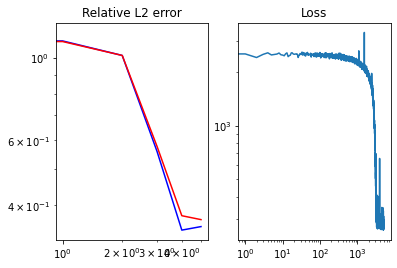

---------------
Epoch 6000 in 4.59 additional seconds
Interior relative error is 0.34493449330329895
Boundary relative error is 0.35794126987457275
Total loss is 259.08447265625
---------------
Epoch 7000 in 2.59 additional seconds
Interior relative error is 0.31832200288772583
Boundary relative error is 0.34196990728378296
Total loss is 264.83782958984375
---------------
Epoch 8000 in 1.82 additional seconds
Interior relative error is 0.2733844220638275
Boundary relative error is 0.29319363832473755
Total loss is 220.52227783203125
---------------
Epoch 9000 in 1.68 additional seconds
Interior relative error is 0.22273418307304382
Boundary relative error is 0.23811574280261993
Total loss is 191.74728393554688
---------------
Epoch 10000 in 1.51 additional seconds
Interior relative error is 0.18566878139972687
Boundary relative error is 0.20571056008338928
Total loss is 181.75506591796875


<Figure size 432x288 with 0 Axes>

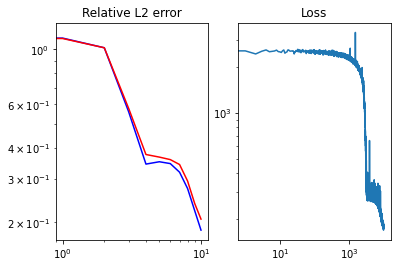

---------------
Epoch 11000 in 2.35 additional seconds
Interior relative error is 0.16259855031967163
Boundary relative error is 0.1836516410112381
Total loss is 171.3464813232422
---------------
Epoch 12000 in 1.52 additional seconds
Interior relative error is 0.1585913449525833
Boundary relative error is 0.1665017008781433
Total loss is 161.3675079345703
---------------
Epoch 13000 in 1.47 additional seconds
Interior relative error is 0.14331981539726257
Boundary relative error is 0.1628323197364807
Total loss is 160.74172973632812
---------------
Epoch 14000 in 1.56 additional seconds
Interior relative error is 0.14259839057922363
Boundary relative error is 0.15426069498062134
Total loss is 156.8569793701172
---------------
Epoch 15000 in 1.87 additional seconds
Interior relative error is 0.13040895760059357
Boundary relative error is 0.14158348739147186
Total loss is 150.43548583984375


<Figure size 432x288 with 0 Axes>

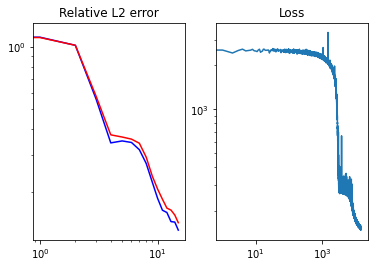

---------------
Epoch 16000 in 2.21 additional seconds
Interior relative error is 0.13584165275096893
Boundary relative error is 0.14552082121372223
Total loss is 150.22308349609375
---------------
Epoch 17000 in 1.48 additional seconds
Interior relative error is 0.13063916563987732
Boundary relative error is 0.14297492802143097
Total loss is 149.5950469970703
---------------
Epoch 18000 in 1.51 additional seconds
Interior relative error is 0.12824231386184692
Boundary relative error is 0.14289040863513947
Total loss is 149.96633911132812
---------------
Epoch 19000 in 1.47 additional seconds
Interior relative error is 0.12983235716819763
Boundary relative error is 0.13569606840610504
Total loss is 143.47586059570312
---------------
Epoch 20000 in 1.46 additional seconds
Interior relative error is 0.13029631972312927
Boundary relative error is 0.1385083794593811
Total loss is 145.18942260742188


<Figure size 432x288 with 0 Axes>

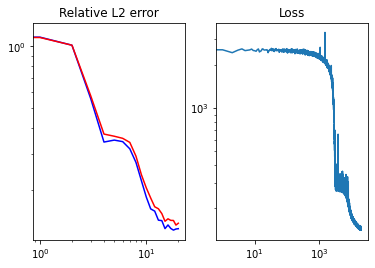

---------------
Epoch 21000 in 2.95 additional seconds
Interior relative error is 0.12878449261188507
Boundary relative error is 0.1365453153848648
Total loss is 143.92794799804688
---------------
Epoch 22000 in 1.44 additional seconds
Interior relative error is 0.12577219307422638
Boundary relative error is 0.13737717270851135
Total loss is 145.30352783203125
---------------
Epoch 23000 in 1.52 additional seconds
Interior relative error is 0.12187273055315018
Boundary relative error is 0.13499896228313446
Total loss is 145.07232666015625
---------------
Epoch 24000 in 1.46 additional seconds
Interior relative error is 0.12718123197555542
Boundary relative error is 0.13606448471546173
Total loss is 144.1607208251953
---------------
Epoch 25000 in 1.52 additional seconds
Interior relative error is 0.12534458935260773
Boundary relative error is 0.1341477930545807
Total loss is 143.24310302734375


<Figure size 432x288 with 0 Axes>

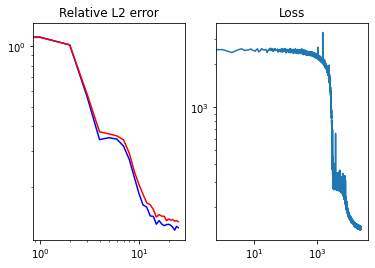

---------------
Epoch 26000 in 2.46 additional seconds
Interior relative error is 0.12564575672149658
Boundary relative error is 0.13521675765514374
Total loss is 142.05392456054688
---------------
Epoch 27000 in 1.95 additional seconds
Interior relative error is 0.13022634387016296
Boundary relative error is 0.1335964798927307
Total loss is 140.24765014648438
---------------
Epoch 28000 in 1.54 additional seconds
Interior relative error is 0.1246165782213211
Boundary relative error is 0.13075587153434753
Total loss is 140.65782165527344
---------------
Epoch 29000 in 1.51 additional seconds
Interior relative error is 0.12311112135648727
Boundary relative error is 0.1316688060760498
Total loss is 139.3316650390625
---------------
Epoch 30000 in 1.49 additional seconds
Interior relative error is 0.1196068823337555
Boundary relative error is 0.1335013508796692
Total loss is 141.72848510742188


<Figure size 432x288 with 0 Axes>

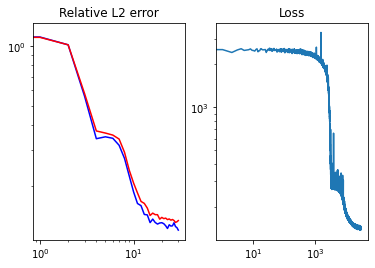

---------------
Epoch 31000 in 2.36 additional seconds
Interior relative error is 0.12239337712526321
Boundary relative error is 0.13462959229946136
Total loss is 141.8664093017578
---------------
Epoch 32000 in 1.51 additional seconds
Interior relative error is 0.1243073046207428
Boundary relative error is 0.13209101557731628
Total loss is 139.53329467773438
---------------
Epoch 33000 in 2.04 additional seconds
Interior relative error is 0.12056688964366913
Boundary relative error is 0.13167791068553925
Total loss is 138.3333740234375
---------------
Epoch 34000 in 1.52 additional seconds
Interior relative error is 0.1261545568704605
Boundary relative error is 0.13190504908561707
Total loss is 140.08822631835938
---------------
Epoch 35000 in 1.51 additional seconds
Interior relative error is 0.12643565237522125
Boundary relative error is 0.13646745681762695
Total loss is 138.19985961914062


<Figure size 432x288 with 0 Axes>

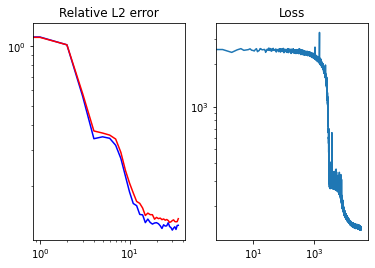

---------------
Epoch 36000 in 3.02 additional seconds
Interior relative error is 0.12554369866847992
Boundary relative error is 0.13528980314731598
Total loss is 138.0657501220703
---------------
Epoch 37000 in 1.48 additional seconds
Interior relative error is 0.12830792367458344
Boundary relative error is 0.1354895979166031
Total loss is 134.52464294433594
---------------
Epoch 38000 in 1.66 additional seconds
Interior relative error is 0.13181538879871368
Boundary relative error is 0.13406364619731903
Total loss is 135.02410888671875
---------------
Epoch 39000 in 1.84 additional seconds
Interior relative error is 0.1277613341808319
Boundary relative error is 0.14010056853294373
Total loss is 135.87185668945312
---------------
Epoch 40000 in 1.70 additional seconds
Interior relative error is 0.13073670864105225
Boundary relative error is 0.13741420209407806
Total loss is 133.92831420898438


<Figure size 432x288 with 0 Axes>

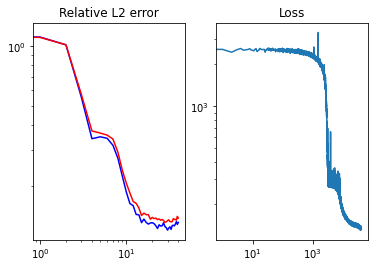

---------------
Epoch 41000 in 2.87 additional seconds
Interior relative error is 0.12415336817502975
Boundary relative error is 0.14157193899154663
Total loss is 135.62442016601562
---------------
Epoch 42000 in 1.49 additional seconds
Interior relative error is 0.13124723732471466
Boundary relative error is 0.14305385947227478
Total loss is 135.36155700683594
---------------
Epoch 43000 in 1.48 additional seconds
Interior relative error is 0.12891435623168945
Boundary relative error is 0.14098331332206726
Total loss is 135.06301879882812
---------------
Epoch 44000 in 1.74 additional seconds
Interior relative error is 0.12817730009555817
Boundary relative error is 0.14237314462661743
Total loss is 135.56024169921875
---------------
Epoch 45000 in 1.69 additional seconds
Interior relative error is 0.12526321411132812
Boundary relative error is 0.14282476902008057
Total loss is 135.84555053710938


<Figure size 432x288 with 0 Axes>

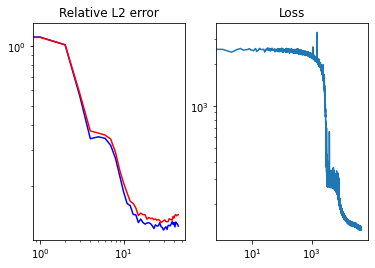

---------------
Epoch 46000 in 2.52 additional seconds
Interior relative error is 0.13065595924854279
Boundary relative error is 0.13857422769069672
Total loss is 131.9093780517578
---------------
Epoch 47000 in 1.53 additional seconds
Interior relative error is 0.13018476963043213
Boundary relative error is 0.13959085941314697
Total loss is 134.49749755859375
---------------
Epoch 48000 in 1.50 additional seconds
Interior relative error is 0.12939301133155823
Boundary relative error is 0.1385437697172165
Total loss is 133.20797729492188
---------------
Epoch 49000 in 1.49 additional seconds
Interior relative error is 0.1360001415014267
Boundary relative error is 0.1425270140171051
Total loss is 135.1617431640625
Epoch 49999 in 1.49 sec
Final loss is  133.42935180664062


In [ ]:
#training loop
import time

flow_losses = []
bdy_losses = []
training_losses = []
flow_residuals = []
bdy_residuals = []

# i=1
# num_epochs = int(1e5) #run for longer
num_epochs = 50000
# num_epochs = 75000
#adam optimizer via optax
opt_state = optimizer.init(params)
start_time = time.time()

for epoch in range(hypers["num epochs"]):
    
    key,train_key = random.split(key)
    
    
    params,opt_state,train_loss = compiled_update(params,opt_state,train_key)
    # params,opt_state,train_loss = compiled_error_update(params,opt_state,train_key)

    # loss = jnp.add(int_loss,bdy_loss)
    training_losses.append(train_loss)
    
    if epoch%1000 == 0:
      

      epoch_time = time.time() - start_time

      keys = random.split(train_key,num=2)
      int_out_batch = get_batch(hypers["batch size"],keys[0])
      bdy_out_batch = get_boundary_batch(hypers["boundary size"],keys[1])

      # flow_output = flow_loss_vector(params,int_out_batch) #these two are for dr loss
      # flow_train_loss = jnp.mean(flow_output)

      flow_train_loss = pinn_loss(params,int_out_batch) # for pinn loss
      
      flow_losses.append(flow_train_loss)

      bdy_output = batched_model(params,bdy_out_batch)
      exact_bdy = exact_vector(bdy_out_batch)
      bdy_diff = bdy_output - exact_bdy
      bdy_train_loss = hypers["beta"]*jnp.mean(bdy_diff*bdy_diff)
      bdy_losses.append(bdy_train_loss)
      bdy_error = jnp.sqrt(jnp.mean(bdy_diff*bdy_diff) / jnp.mean(exact_bdy**2)) #don't need penalty param here
      # bdy_error = jnp.sqrt(jnp.sum(bdy_diff*bdy_diff) / jnp.sum(exact_bdy**2)) #don't need penalty param here
      bdy_residuals.append(bdy_error)

      exact_int = exact_vector(int_out_batch)
      int_output = batched_model(params,int_out_batch)
      int_error = jnp.sqrt(jnp.mean((exact_int - int_output)**2)/jnp.mean(exact_int**2))
      # int_error = jnp.sqrt(jnp.sum((exact_int - int_output)**2)/jnp.sum(exact_int**2)) 
      #error is measured in relative L2 error
      flow_residuals.append(int_error)

      start_time = time.time()
      print("---------------")
      print("Epoch {} in {:0.2f} additional seconds".format(epoch, epoch_time))
      
      print(f'Interior relative error is {int_error}')
      print(f'Boundary relative error is {bdy_error}')
      print("Total loss is {}".format(train_loss))
    #end if

    if epoch%5000 == 0 and epoch!= 0:
      plt.clf()
      fig,axs = plt.subplots(nrows=1,ncols=2)
      axs[0].loglog(flow_residuals,'b')
      axs[0].loglog(bdy_residuals,'r')
      axs[0].set_title("Relative L2 error")
      axs[1].loglog(training_losses)
      # axs[1].loglog(,'r')
      axs[1].set_title("Loss")
      plt.show()
    #end if

#end for
    
#once loops ends    
print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time)) #print final epoch info
print("Final loss is  {}".format(train_loss))



final flow residual error is 0.1360001415014267
final boundary residual error is 0.1425270140171051
total final error is 0.2785271406173706


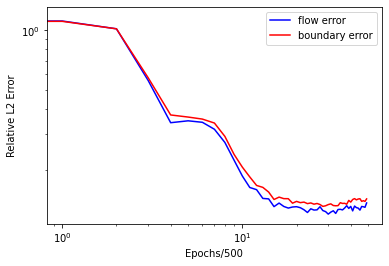

In [ ]:
plt.clf()
# plt.loglog(flow_residuals,'b',label="flow error")
# plt.loglog(bdy_residuals,'r',label = 'boundary error')
# plt.legend()
# plt.xlabel("Epochs/1000")
# plt.ylabel("Relative L2 Error")
# # plt.show()
# plt.savefig("10D-ff-pinn-error.png")

fig,axs = plt.subplots(nrows=1,ncols=2)
axs[0].loglog(flow_residuals,'b')
axs[0].loglog(bdy_residuals,'r')
axs[0].set_title("Relative L2 error")
axs[0].xlabel("Epochs/1000")
axs[0]
axs[1].loglog(training_losses)
      # axs[1].loglog(,'r')
axs[1].set_title("Loss")
plt.show()

print(f'final flow residual error is {flow_residuals[-1]}')
print(f'final boundary residual error is {bdy_residuals[-1]}')
print(f'total final error is {jnp.add(flow_residuals[-1],bdy_residuals[-1])}')

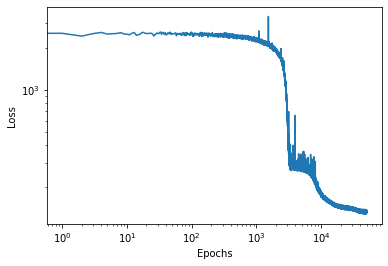

In [ ]:
plt.clf()
plt.loglog(training_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("10d-ff-pinn-loss.png")

In [ ]:
# params